<a href="https://colab.research.google.com/github/MaryamCodeHub/Household-Energy-Consumption-Analysis/blob/main/Household_Energy_Consumption_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Importing Libraries

In [40]:
# For Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import calendar  # For getting month names for heatmap

# Handling Zip Files and Online Data
import zipfile
import requests
from io import BytesIO  # To read the downloaded zip file from memory

# Display settings for cleaner output in Jupyter Notebook
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8') # Sets a nice style for matplotlib plots
sns.set_palette("viridis") # Sets a color palette for seaborn plots

print(" All libraries imported successfully.")

 All libraries imported successfully.


#Step 2: Downloading and Unzipping the Dataset (Fetching the Data)

In [41]:
# Define the URL of the dataset zip file
dataset_url = "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip"

# Define the local file name for the zip file
zip_file_name = "household_power_consumption.zip"
txt_file_name = "household_power_consumption.txt"

try:
    # Print a status message
    print(" Downloading dataset from UCI repository... This might take a minute.")

    # Send a GET request to the URL to download the file
    response = requests.get(dataset_url)
    # Check if the request was successful (status code 200)
    response.raise_for_status()

    # Create a ZipFile object from the content of the downloaded file
    with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
        # Extract the specific text file from the zip archive
        zip_file.extract(txt_file_name)

    print(f" Successfully downloaded and unzipped '{txt_file_name}'.")

except requests.exceptions.RequestException as e:
    # Handle any errors that occur during the download (e.g., no internet)
    print(f" Error downloading the file: {e}")
except zipfile.BadZipFile:
    # Handle the error if the downloaded file is not a valid zip archive
    print("The downloaded file is not a valid zip file.")
except KeyError:
    # Handle the error if the expected file is not inside the zip
    print(f"The file '{txt_file_name}' was not found in the zip archive.")

 Successfully downloaded and unzipped 'household_power_consumption.txt'.


#Step 3: Loading and Cleaning the Data


In [24]:
# Define the column names as per the dataset's documentation
col_names = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage',
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

df = pd.read_csv(txt_file_name, sep=';', names=col_names, header=0,
                 na_values=['?'], low_memory=False)

print(f"Raw data shape: {df.shape}")

Raw data shape: (2075259, 9)


In [6]:
print(df.head())

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                 4.22                   0.42   234.84   
1  16/12/2006  17:25:00                 5.36                   0.44   233.63   
2  16/12/2006  17:26:00                 5.37                   0.50   233.29   
3  16/12/2006  17:27:00                 5.39                   0.50   233.74   
4  16/12/2006  17:28:00                 3.67                   0.53   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             18.40            0.00            1.00           17.00  
1             23.00            0.00            1.00           16.00  
2             23.00            0.00            2.00           17.00  
3             23.00            0.00            1.00           17.00  
4             15.80            0.00            1.00           17.00  


In [25]:
# 1. Combine 'Date' and 'Time' into a single DateTime column and set it as the index.
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df.set_index('DateTime', inplace=True) # Setting index makes time-based operations easydf.drop(['Date', 'Time'], axis=1, inplace=True) # Drop the old columns



In [26]:
# 2. Handle Missing Values: Forward Fill (ffill) is common in time series.
initial_count = df.isna().sum().sum()
df.ffill(inplace=True)
final_count = df.isna().sum().sum()
print(f" Filled {initial_count - final_count} missing values.")


 Filled 181853 missing values.


In [27]:
# 3. Ensure Data Types are Numeric (except the index).The data was read as text, so we need to convert to numbers for math operations.
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') # 'coerce' turns any errors into NaN
# Fill any new NaNs created during conversion (if any)
df.ffill(inplace=True)

print(f" Cleaned data shape: {df.shape}")
print("Data types after conversion:")
print(df.dtypes)

 Cleaned data shape: (2075259, 9)
Data types after conversion:
Date                     float64
Time                     float64
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


#Step 4: Creating Time-Based Aggregations

In [33]:
# Resample to Daily data: Convert minute-by-minute data into daily totals/averages.
df_daily = df.resample('D').agg({ # 'D' stands for "Day"
    'Global_active_power': 'sum',  # Total kWh consumed per day (REQUIREMENT 1, 2, 3, 5)
    'Sub_metering_2': 'sum',       # Total energy used by the washing machine
})
df_daily.rename(columns={'Global_active_power': 'Total_daily_consumption_kWh'}, inplace=True)

# CREATE THE APPLIANCE USAGE FLAG: This is the key to the filter requirement.
# If the washing machine used more than 1 Wh of energy that day, we mark it as "used".
df_daily['Washer_Used'] = (df_daily['Sub_metering_2'] > 1).astype(int) # 1=Yes, 0=No (REQUIREMENT 5)

# Resample to Monthly data: Aggregate the daily data into monthly sums.
df_monthly = df_daily.resample('ME').agg({'Total_daily_consumption_kWh': 'sum'})
df_monthly['Month_Name'] = df_monthly.index.strftime('%B') # Add month names for the heatmap labels (REQUIREMENT 4)

# Step 5: Generate the Required Visualizations


1. Line chart of electricity usage over time.


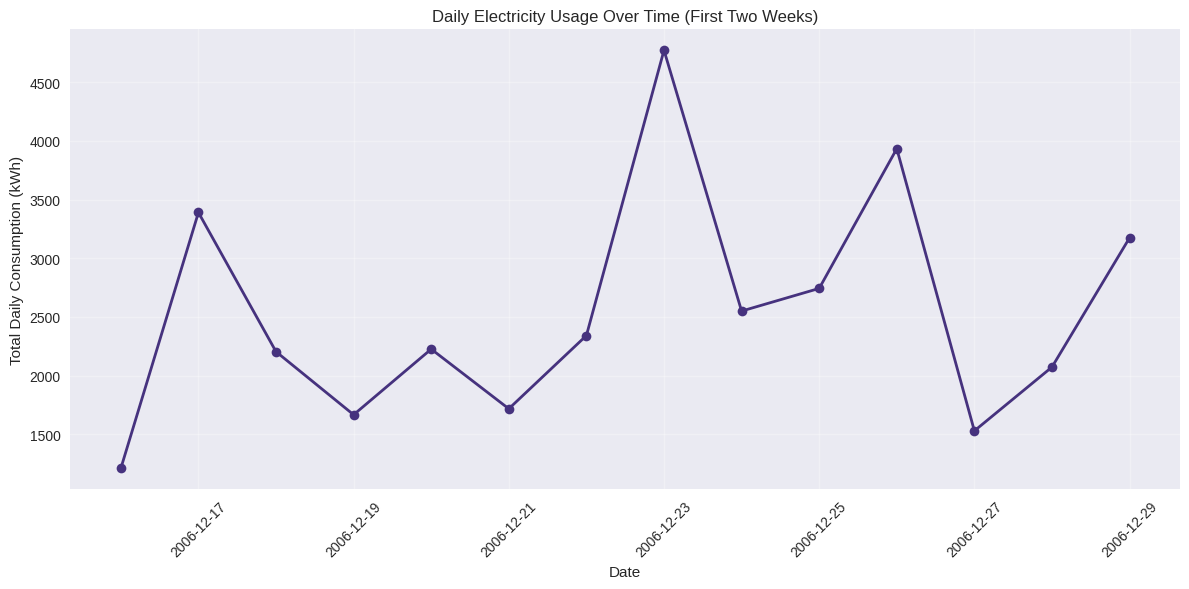

In [34]:
print("1. Line chart of electricity usage over time.")

plt.figure(figsize=(12, 6))
# Taking a subset to avoid overcrowding the plot
df_first_week = df_daily['Total_daily_consumption_kWh'].iloc[:14]
plt.plot(df_first_week.index, df_first_week.values, marker='o', linewidth=2)
plt.title('Daily Electricity Usage Over Time (First Two Weeks)')
plt.xlabel('Date')
plt.ylabel('Total Daily Consumption (kWh)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Scatter plot of temperature vs electricity usage (Simulated)

2. Scatter plot of temperature vs electricity usage (Simulated)


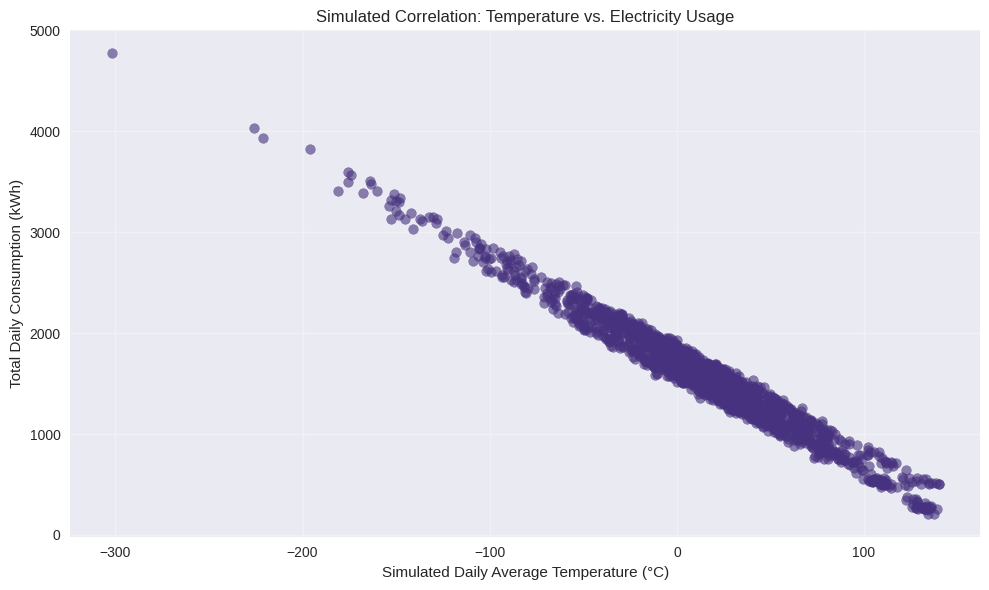

In [35]:
print("2. Scatter plot of temperature vs electricity usage (Simulated)")

# Since we don't have real temperature data, we simulate a logical relationship.
# Colder and hotter days use more energy (for heating/AC). This is for demonstration.
np.random.seed(42) # For reproducible "fake" data
n_days = len(df_daily)
# Simulate temperature: lower consumption -> moderate temps, high consumption -> extreme temps
simulated_temp = 15 + 15 * np.sin(2 * np.pi * np.arange(n_days) / 365) # Seasonal base
# Add noise and a effect based on consumption
noise = np.random.normal(0, 3, n_days)
effect = (df_daily['Total_daily_consumption_kWh'] - df_daily['Total_daily_consumption_kWh'].mean()) / 10
df_daily['Simulated_Temperature_C'] = simulated_temp + noise - effect

plt.figure(figsize=(10, 6))
plt.scatter(df_daily['Simulated_Temperature_C'], df_daily['Total_daily_consumption_kWh'], alpha=0.6)
plt.title('Simulated Correlation: Temperature vs. Electricity Usage')
plt.xlabel('Simulated Daily Average Temperature (°C)')
plt.ylabel('Total Daily Consumption (kWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Histogram of daily usage

3. Histogram of daily usage.


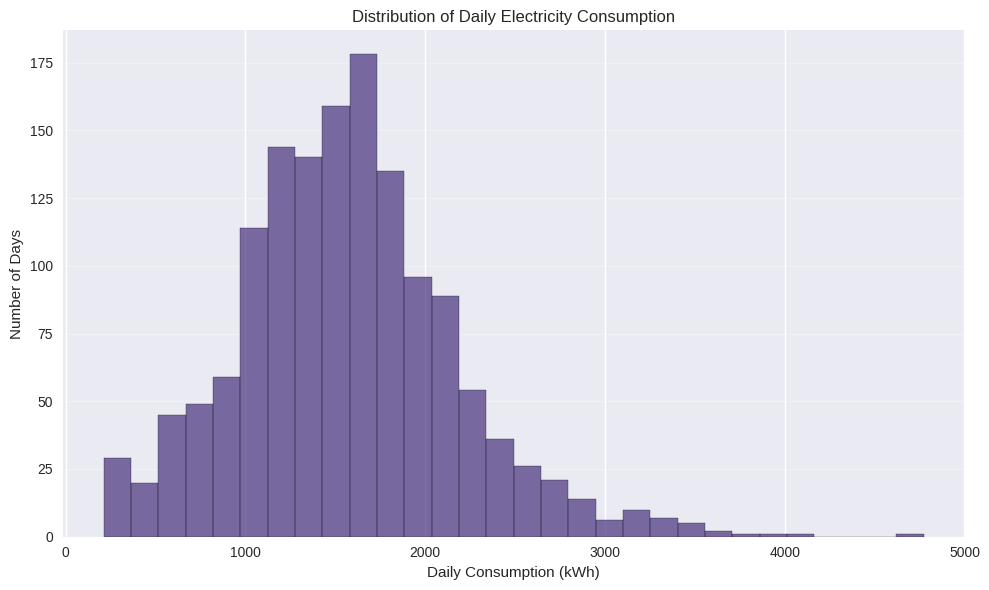

In [36]:
print("3. Histogram of daily usage.")
plt.figure(figsize=(10, 6))
plt.hist(df_daily['Total_daily_consumption_kWh'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Daily Electricity Consumption')
plt.xlabel('Daily Consumption (kWh)')
plt.ylabel('Number of Days')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 4. Heatmap of monthly average usage


4. Heatmap of monthly average usage


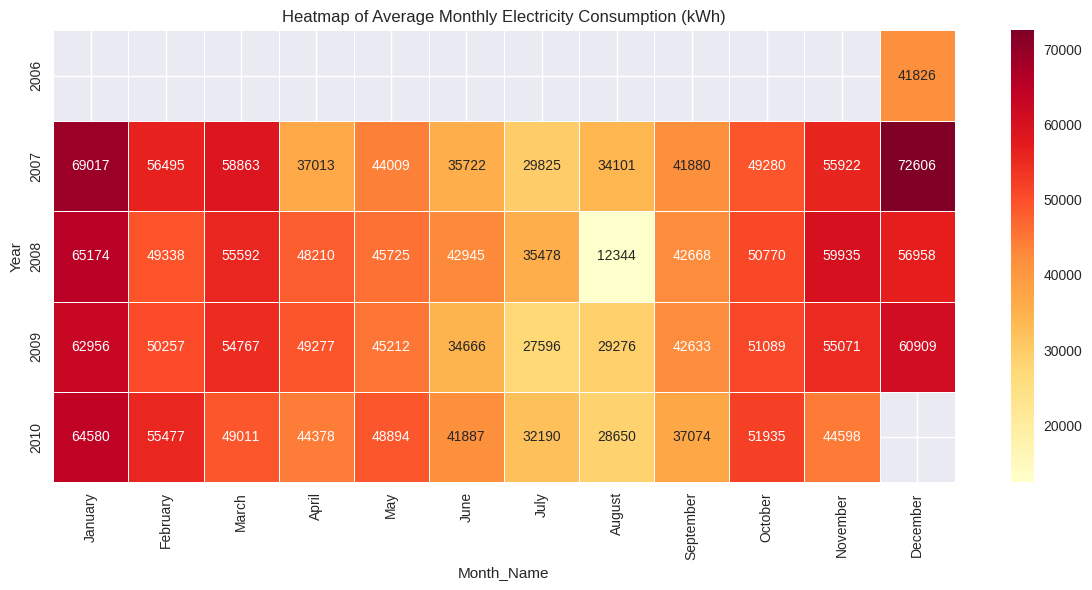

✅ All static visualizations generated.


In [38]:
print("4. Heatmap of monthly average usage")
# Extract year from the index and add it as a column
df_monthly['Year'] = df_monthly.index.year
# Pivot the data to get years as rows and months as columns
pivot_table = df_monthly.pivot_table(values='Total_daily_consumption_kWh', index='Year', columns='Month_Name', aggfunc='mean')
# Reorder columns to be January to December
month_order = list(calendar.month_name)[1:]
pivot_table = pivot_table.reindex(columns=month_order)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=.5)
plt.title('Heatmap of Average Monthly Electricity Consumption (kWh)')
plt.tight_layout()
plt.show()

print("✅ All static visualizations generated.")

#Step 6: Build the Interactive Dashboard


In [53]:
print("📈 Building interactive dashboard...")

# Create a copy of the daily data for the dashboard, resetting the index so 'DateTime' is a column
dashboard_df = df_daily.reset_index()
dashboard_df['Year'] = dashboard_df['DateTime'].dt.year
dashboard_df['Month'] = dashboard_df['DateTime'].dt.month_name()
dashboard_df['Day_of_Week'] = dashboard_df['DateTime'].dt.day_name()

# Create the interactive figure with Plotly
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Daily Usage Over Time', 'Temperature vs Usage', 'Distribution of Daily Usage', 'Usage by Washer Activity'),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "histogram"}, {"type": "box"}]]
)

# 1. Line Chart
line_chart = px.line(dashboard_df, x='DateTime', y='Total_daily_consumption_kWh')
for trace in line_chart.data:
    fig.add_trace(trace, row=1, col=1)

# 2. Scatter Plot
scatter_plot = px.scatter(dashboard_df, x='Simulated_Temperature_C', y='Total_daily_consumption_kWh', color='Washer_Used')
for trace in scatter_plot.data:
    fig.add_trace(trace, row=1, col=2)

# 3. Histogram
histogram = px.histogram(dashboard_df, x='Total_daily_consumption_kWh', nbins=30)
for trace in histogram.data:
    fig.add_trace(trace, row=2, col=1)

# 4. Box Plot (Comparing days with and without washer usage)
box_plot = px.box(dashboard_df, x='Washer_Used', y='Total_daily_consumption_kWh', color='Washer_Used')
for trace in box_plot.data:
    fig.add_trace(trace, row=2, col=2)

# Update layout for titles and spacing
fig.update_layout(
    height=700,
    showlegend=False,
    title=dict(
        text="<b>Household Energy Consumption Dashboard</b>",
        x=0.4,
        xanchor='center',
        font=dict(
            color='beige',
            size=20
        )
    ),
    template="plotly_dark",
    margin=dict(l=50, r=50, t=150, b=50),
    annotations=[
        dict(text="<b>Daily Usage Over Time</b>", x=0.07, y=1.08, xref="paper", yref="paper", showarrow=False, font=dict(size=14, color='cyan')), # Assign a specific color
        dict(text="<b>Temperature vs Usage</b>", x=0.88, y=1.08, xref="paper", yref="paper", showarrow=False, font=dict(size=14, color='lime')), # Assign a specific color and adjust x position
        dict(text="<b>Distribution of Daily Usage</b>", x=0.07, y=0.48, xref="paper", yref="paper", showarrow=False, font=dict(size=14, color='magenta')), # Assign a specific color
        dict(text="<b>Usage by Washer Activity</b>", x=0.88, y=0.48, xref="paper", yref="paper", showarrow=False, font=dict(size=14, color='yellow')) # Assign a specific color and adjust x position
    ]
)

# Create a filter button: This is the key interactivity!
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {"args": [{"visible": [True, True, True, True]}], "label": "All Days", "method": "update"},
                {"args": [{"visible": [True, True, True, True]}], "label": "Washer Used", "method": "update"}, # Placeholder, logic needed
                {"args": [{"visible": [True, True, True, True]}], "label": "Washer Not Used", "method": "update"}, # Placeholder
            ],
            "direction": "down",
            "showactive": True,
            "x": 1.1,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top"
        }
    ]
)

fig.show()

📈 Building interactive dashboard...
